In [1]:
%matplotlib inline

# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def interactive_view(img):
    size = img.GetSize() 
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)));

Reading directory: /Volumes/FAIR/Eric_Midlinedeliniation/MPS1/1bLs736 - 80340.nii.gz


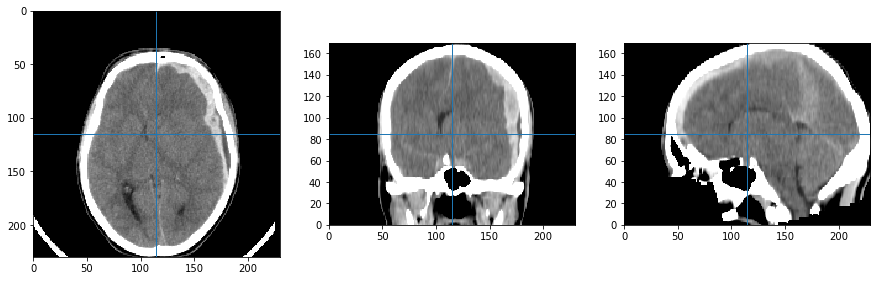

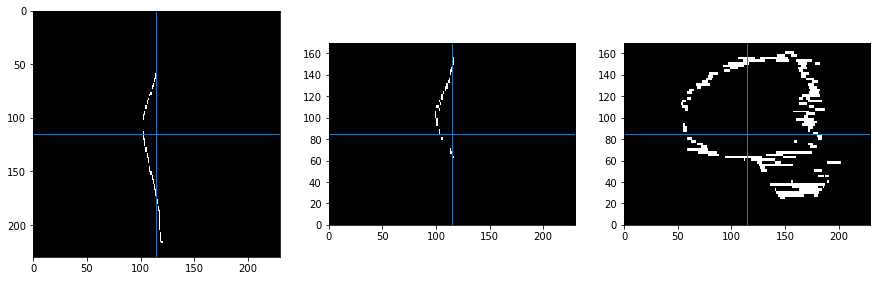

In [2]:
# Use full browser width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

%matplotlib inline 

paths = ['/Volumes/FAIR/Eric_Midlinedeliniation/MPS1/1bLs736 - 80340.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS2/1kAg181-2.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS3/1kvR906 - 3.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS4/1YaA080 - 3.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS5/2bai335 - 6.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS6/2bjs359 - 4.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS7/2dgm988 - 601.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS8/2FfC223 - 2.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS9/2uTT322 - 2.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS10/2VAp647 - 200.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS11/2viJ294 - 2.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS12/2wbs775 - 5.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS13/3BSL889 - 250.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/MPS14/3DJe857 - 252.nii.gz',
         ]

# for i in range(len(paths)):
for i in range(0,1):
    path = paths[i]
    print( "Reading directory:", path)
    file = os.path.split(os.path.split(path)[0])[1]
    dir_name = os.path.split(path)[0]
    img = sitk.Cast(sitk.ReadImage(path), sitk.sitkFloat32)
    mps = sitk.ReadImage(dir_name + '/mls.nii.gz')
    
    dimension = img.GetDimension()
    old_spacing = img.GetSpacing()
    old_size = img.GetSize()

    # reference_direction = np.identity(dimension).flatten()
    reference_direction = (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
    reference_size = [200,200,200]
    reference_spacing = [old_spacing[d] * old_size[d] / reference_size[d] for d in range(3)]
    reference_origin = np.zeros(dimension)

    reference_image = sitk.Image(reference_size, img.GetPixelIDValue())
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)
    reference_center = np.array(
        reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize()) / 2.0))

    transform = sitk.AffineTransform(dimension) # use affine transform with 3 dimensions
    transform.SetMatrix(img.GetDirection()) # set the cosine direction matrix
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin) # set the translation.
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize()) / 2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform.AddTransform(centering_transform)
    
    resampled_img = sitk.Resample(img, reference_image, centered_transform, sitk.sitkLinear, 0.0)
    resampled_mps = sitk.Resample(mps, reference_image, centered_transform, sitk.sitkNearestNeighbor, 0.0)

    resampled_img.GetOrigin(),
    resampled_img.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
    resampled_mps.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))

    sitk.WriteImage(resampled_img, dir_name + '/' + file + '_Resampled.nii.gz')
    sitk.WriteImage(resampled_mps, dir_name + '/' + 'mps_Resampled.nii.gz')

    display_image(resampled_img, window=90, level=40)
    display_image(resampled_mps)



Reading directory: /Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/tutorial3/ct-brain.nii.gz


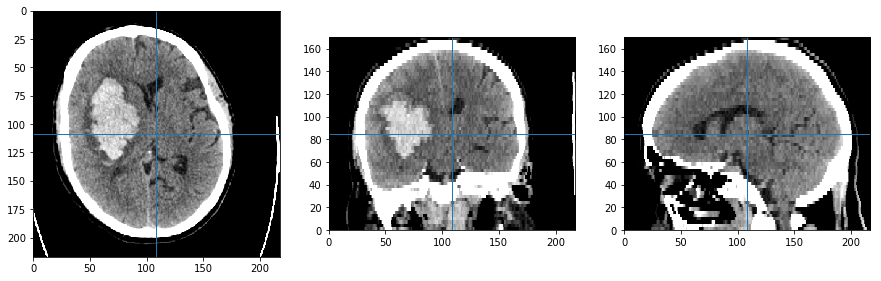

In [7]:
# Use full browser width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

%matplotlib inline 

# paths = ['/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH2/1777243_13410770_02_140806_2233_002_ThinSliceSeq_4_0_H40s_image.nii.gz',
#          '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH4/3708063_10968221_01_310816_2010_002_Head_5_0_MPR_image.nii.gz',
#          '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH7/m_3742364_11045234_01_211016_0208_002_Head_5_0_J40s_3_image.nii.gz',
#          '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH8/3758895_11066947_01_041116_0009_007_Head_5_0_J40s_3_image.nii.gz',
#          '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH9/3764350_##_01_131116_0152_002_Head_5_0_J40s_3_image.nii.gz',
#          '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH11/3797770_23590_01_221216_0345_002_Head_5_0_image.nii.gz',
#          '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH12/3798130_43976_01_040117_2338_002_Brain_2_5_5mm_SS40_image.nii.gz',
#         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH14/6vqQ294_CT1.nii.gz',
#         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH16-2/ct_20215_2_image.nii.gz',
#         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH24/ct_12715_image.nii.gz',
#          '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/CONT4/1805902_13598258_01_100407_1814_002_ThinSliceSeq_4_0_H40s_image.nii.gz',
#          '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/CONT5/g_3487946_10590242_01_161215_0440_002_Head_5_0_J40s_3_image.nii.gz',
#          '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/CONT7/3797961_76845_02_010117_2344_002_Head_5_0_image.nii.gz',
#         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/EDH7/3799763_93620_01_231216_1823_80256_MPR_image.nii.gz',
#         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample3_Pre/S3_Pre-op.nrrd',
#         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample3_Post/S3_Post-op.nrrd',
#         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample4_Pre/S4_Pre-op.nrrd',
#         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/tutorial3/ct-brain.nii.gz',
#         ]

paths = ['/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/tutorial3/ct-brain.nii.gz',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample4_pre/S4_Pre-op.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/ScanE/img.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/ScanF/img.nii.gz',
         '/Volumes/FAIR/Registered_MPS3/ScanH/CT_Resampled.nii.gz',
         ]

# for i in range(len(paths)):
for i in range(0,1):
    path = paths[i]
    print( "Reading directory:", path)
    file = os.path.split(path)[1]
    dir_name = os.path.split(path)[0]
    img = sitk.Cast(sitk.ReadImage(path), sitk.sitkFloat32)
#     mps = sitk.ReadImage(dir_name + '/mls.nii.gz')
    seg = sitk.ReadImage(dir_name + '/ct-brain-lesion.nii.gz')
    
    dimension = img.GetDimension()
    old_spacing = img.GetSpacing()
    old_size = img.GetSize()

    # reference_direction = np.identity(dimension).flatten()
    reference_direction = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
    reference_size = [400,400,60]
    reference_spacing = [old_spacing[d] * old_size[d] / reference_size[d] for d in range(3)]
    reference_origin = np.zeros(dimension)

    reference_image = sitk.Image(reference_size, img.GetPixelIDValue())
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)
    reference_center = np.array(
        reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize()) / 2.0))

    transform = sitk.AffineTransform(dimension) # use affine transform with 3 dimensions
    transform.SetMatrix(img.GetDirection()) # set the cosine direction matrix
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin) # set the translation.
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize()) / 2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform.AddTransform(centering_transform)
    
    resampled_img = sitk.Resample(img, reference_image, centered_transform, sitk.sitkLinear, -1000.0)
#     resampled_mps = sitk.Resample(mps, reference_image, centered_transform, sitk.sitkNearestNeighbor, -1000.0)
    resampled_seg = sitk.Resample(seg, reference_image, centered_transform, sitk.sitkNearestNeighbor, -1000.0)


    resampled_img.GetOrigin(),
    resampled_img.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
#     resampled_mps.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
#     resampled_seg.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))



#     sitk.WriteImage(resampled_img, dir_name + '/' + 'CT_Resampled.nii.gz')
#     sitk.WriteImage(resampled_mps, dir_name + '/' + 'mps_Resampled.nii.gz')
    sitk.WriteImage(resampled_seg, dir_name + '/' + 'seg_Resampled.nii.gz')



    display_image(resampled_img, window=90, level=40)
#     display_image(resampled_mps)




In [17]:
mps.GetDirection(),img.GetDirection()

((1.0,
  0.0,
  0.0,
  0.0,
  0.9925461523301267,
  0.12186933767147677,
  0.0,
  -0.12186933779528412,
  0.9925461523453283),
 (1.0,
  0.0,
  0.0,
  0.0,
  0.9925461523301267,
  0.12186933767147677,
  0.0,
  -0.12186933779528412,
  0.9925461523453283))